# Explorative study on attenuation densities in the lungs

In [6]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import *


In [7]:
%%capture
# Import from different folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")

sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy

In [8]:
# Define paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'
cropped_lung_ct_path = data_path + '/cropped_lungs_ct/*.nii.gz'
file_paths = glob.glob(cropped_lung_ct_path)

### Load data of attenuation arrays with vessels

In [ ]:
# List the files in the attenuation directory
rows = []
for path in file_paths:
    arr = load_nifti_convert_to_numpy(input_path=path)
    arr = arr.flatten()
    patient_id = os.path.basename(path)[7:10]
    new_row = {
        'attenuation': arr,
        'patient': patient_id,
        'label': 'sick' if int(patient_id) < 14 else 'healthy',
        'average_attenuation': np.mean(arr),
        'hpdr': get_hpdr(arr),
    }
    rows.append(new_row)

In [ ]:
df_with_vessels = pd.DataFrame(rows).sort_values('patient')
df_with_vessels = df_with_vessels.reset_index(drop=True)
df_with_vessels

In [ ]:
print(len(df_with_vessels['attenuation'][0]))
print(len(df_with_vessels['attenuation'][1]))


14384381
27831637


### Load data of attenuation arrays without vessels

In [ ]:
# List the files in the attenuation directory
attenuation_list = os.listdir('attenuation')
rows = []
for file in attenuation_list:
    arr = np.load('attenuation/' + file)  # Load the attenuation data
    patient_id = file[27:29]  # Extract patient ID from the filename
    new_row = {
        'attenuation': arr,
        'patient': patient_id,
        'label': 'sick' if int(patient_id) < 14 else 'healthy',
        'average_attenuation': np.mean(arr),
        'hpdr': get_hpdr(arr),
    }
    rows.append(new_row)

#sort df on patient

df_wo = pd.DataFrame(rows).sort_values('patient')
df_wo= df_wo.reset_index(drop=True)

df_wo

,Attenuation,patient,label,average_attenuation,hpdr
0,"[-197, -91, 54, 205, 358, -223, -51, 156, 274,...",00,sick,-816.638245,0.151507
1,"[429, 399, 307, 174, 14, -53, -61, 260, 159, 5...",01,sick,-842.769791,0.068237
2,"[-278, -277, -259, -209, -161, -108, -50, -329...",02,sick,-843.162670,0.091599
3,"[132, 275, -82, 146, -165, -44, -276, -160, -3...",03,sick,-803.534045,0.135776
4,"[232, 200, 203, 143, 110, 40, 264, 169, 141, 1...",04,sick,-839.604597,0.090160
5,"[-235, -189, -167, -108, -104, -345, -339, -29...",05,sick,-799.773890,0.127014
6,"[-815, -778, -531, -784, -643, -482, -790, -73...",06,sick,-849.531030,0.092073
7,"[-396, -415, -403, -388, -381, -371, -364, -43...",07,sick,-819.428742,0.102392
8,"[-91, -140, -141, -166, -204, -258, -247, -155...",08,sick,-849.661217,0.066467
9,"[-243, -192, -138, -305, -240, -179, -346, -26...",09,sick,-869.009088,0.052635


In [115]:
#compare the average attenuation of the two dataframes
df_with_vessels['average_attenuation'][1].mean(), df_wo['average_attenuation'][1].mean()

(-818.1100097346052, -842.7697910179738)

In [ ]:

# attenuation_list = os.listdir('attenuation')
# df = pd.DataFrame(index=[id[27:29] for id in attenuation_list],columns=['attenuation', 'label', 'average_attenuation'])
# for file in attenuation_list:
#     arr = np.load('attenuation/'+file)
#     patient_id=file[27:29]
#     if int(patient_id) < 14:
#         df.loc[str(patient_id),'attenuation'] = arr
#         df.loc[str(patient_id),'label'] = 'sick'
#     elif int(patient_id) >= 14:
#         df.loc[str(patient_id),'attenuation'] = arr
#         df.loc[str(patient_id),'label'] = 'healthy'
# df['average_attenuation'] = df['attenuation'].apply(lambda x: np.mean(x))
# df


# Investigating attenuation densities with vessels

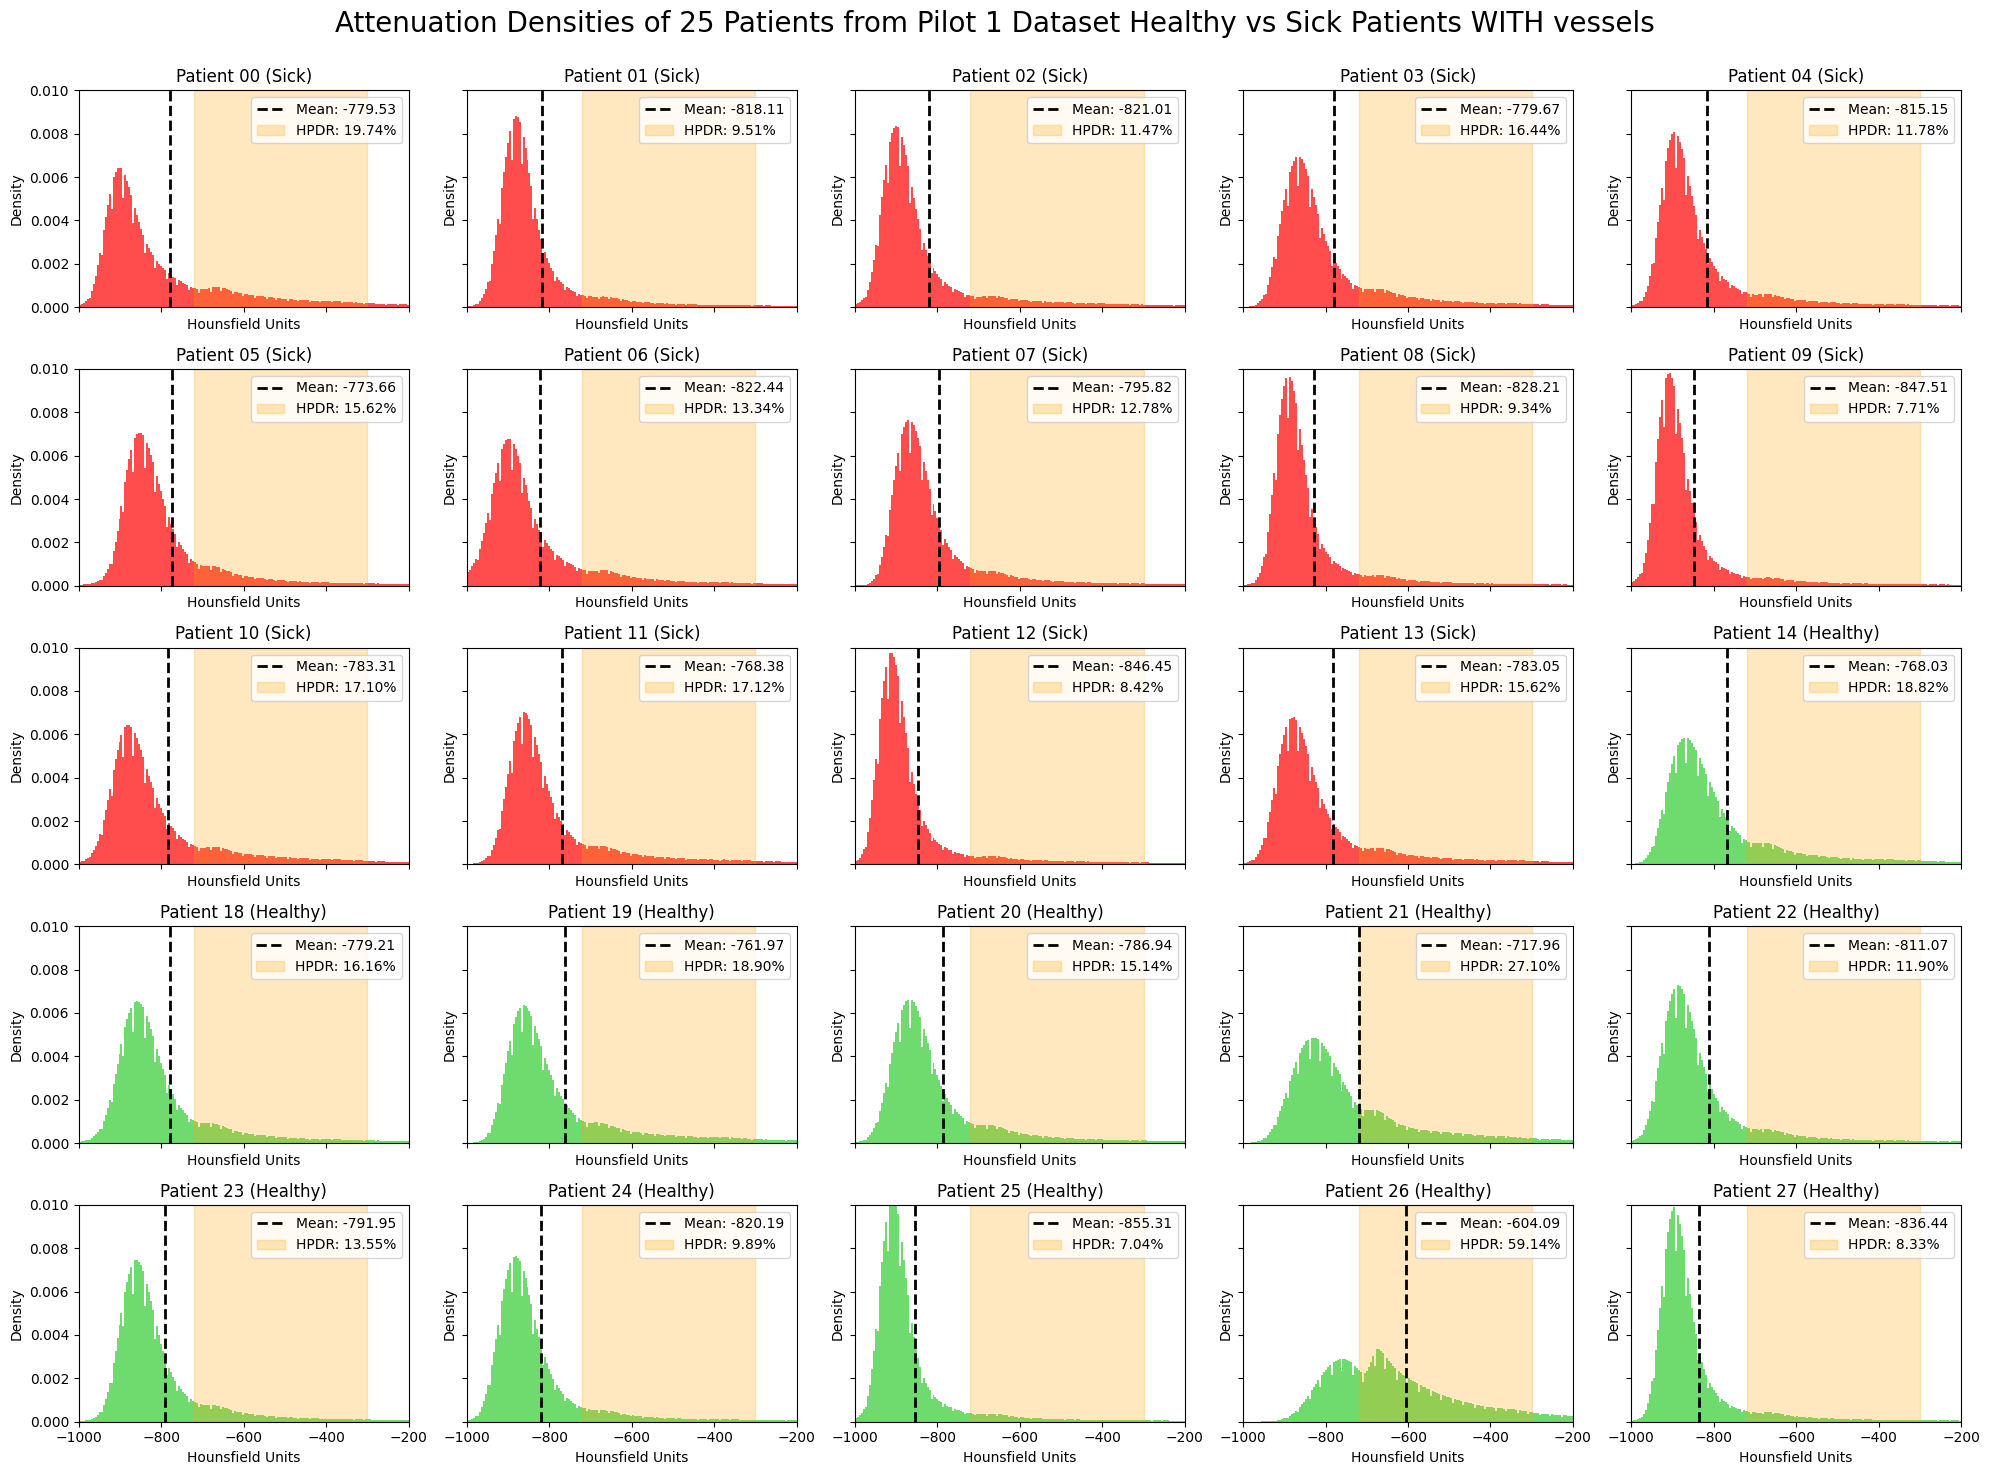

In [ ]:
# Calculate the number of plots required (5 columns per row)
total_patients = len(df_with_vessels)
cols = 5
rows = (total_patients + cols - 1) // cols  # Round up to nearest whole row

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)

# Flatten axes to easily index into them
axes = axes.flatten()

# Define bins for all histograms
bins = np.linspace(-1000, 200, 250)

# Counter to track the subplot index
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df_with_vessels.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'limegreen' if label == 'healthy' else 'red'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('attenuation Densities of 25 Patients from Pilot 1 Dataset Healthy vs Sick Patients WITH vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

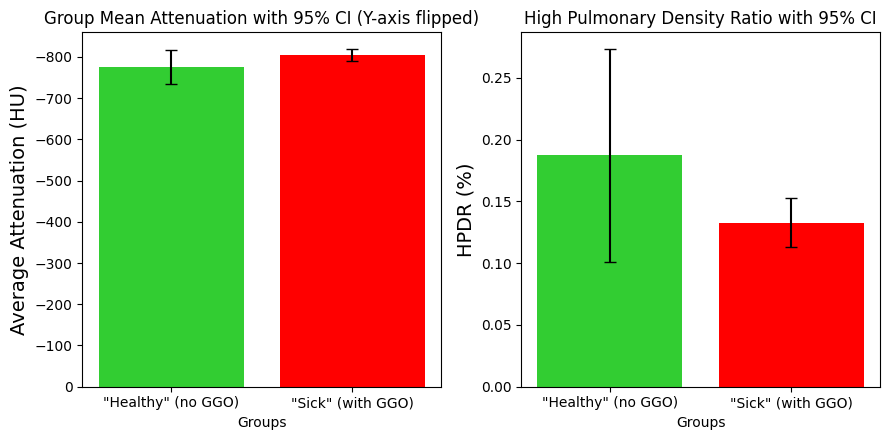

In [ ]:

# Calculate mean and standard error for attenuation
group_mean_attenuation = df_with_vessels.groupby('label')['average_attenuation'].mean()
group_sem_attenuation = df_with_vessels.groupby('label')['average_attenuation'].sem()

# Calculate 95% confidence interval range for attenuation
ci_attenuation = 1.96 * group_sem_attenuation

# Calculate mean and standard error for HPDR
group_mean_hpdr = df_with_vessels.groupby('label')['hpdr'].mean()
group_sem_hpdr = df_with_vessels.groupby('label')['hpdr'].sem()

# Calculate 95% confidence interval range for HPDR
ci_hpdr = 1.96 * group_sem_hpdr

# Define colors for each group (same for both plots)
colors = ['limegreen' if label == 'healthy' else 'red' for label in group_mean_attenuation.index]

# Define custom x-axis labels
custom_labels = ['"Healthy" (no GGO)', '"Sick" (with GGO)']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot 1: attenuation with flipped y-axis
ax1.bar(x=group_mean_attenuation.index, height=group_mean_attenuation, yerr=ci_attenuation, capsize=4, color=colors)
ax1.set_xlabel('Groups')
ax1.set_ylabel('Average attenuation (HU)', fontsize=14)
ax1.set_title('Group Mean attenuation with 95% CI (Y-axis flipped)')
ax1.invert_yaxis()  # Flip the y-axis

# Set x-ticks and labels for the first plot
ax1.set_xticks(np.arange(len(group_mean_attenuation)))  # Set the x-ticks based on the number of groups
ax1.set_xticklabels(custom_labels) 

# Plot 2: HPDR
ax2.bar(x=group_mean_hpdr.index, height=group_mean_hpdr, yerr=ci_hpdr, capsize=4, color=colors)
ax2.set_xlabel('Groups')
ax2.set_ylabel('HPDR (%)', fontsize=14)
ax2.set_title('High Pulmonary Density Ratio with 95% CI')

# Set x-ticks and labels for the second plot
ax2.set_xticks(np.arange(len(group_mean_hpdr)))  # Set the x-ticks based on the number of groups
ax2.set_xticklabels(custom_labels) 

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

# Investigating attenuation densities without vessels

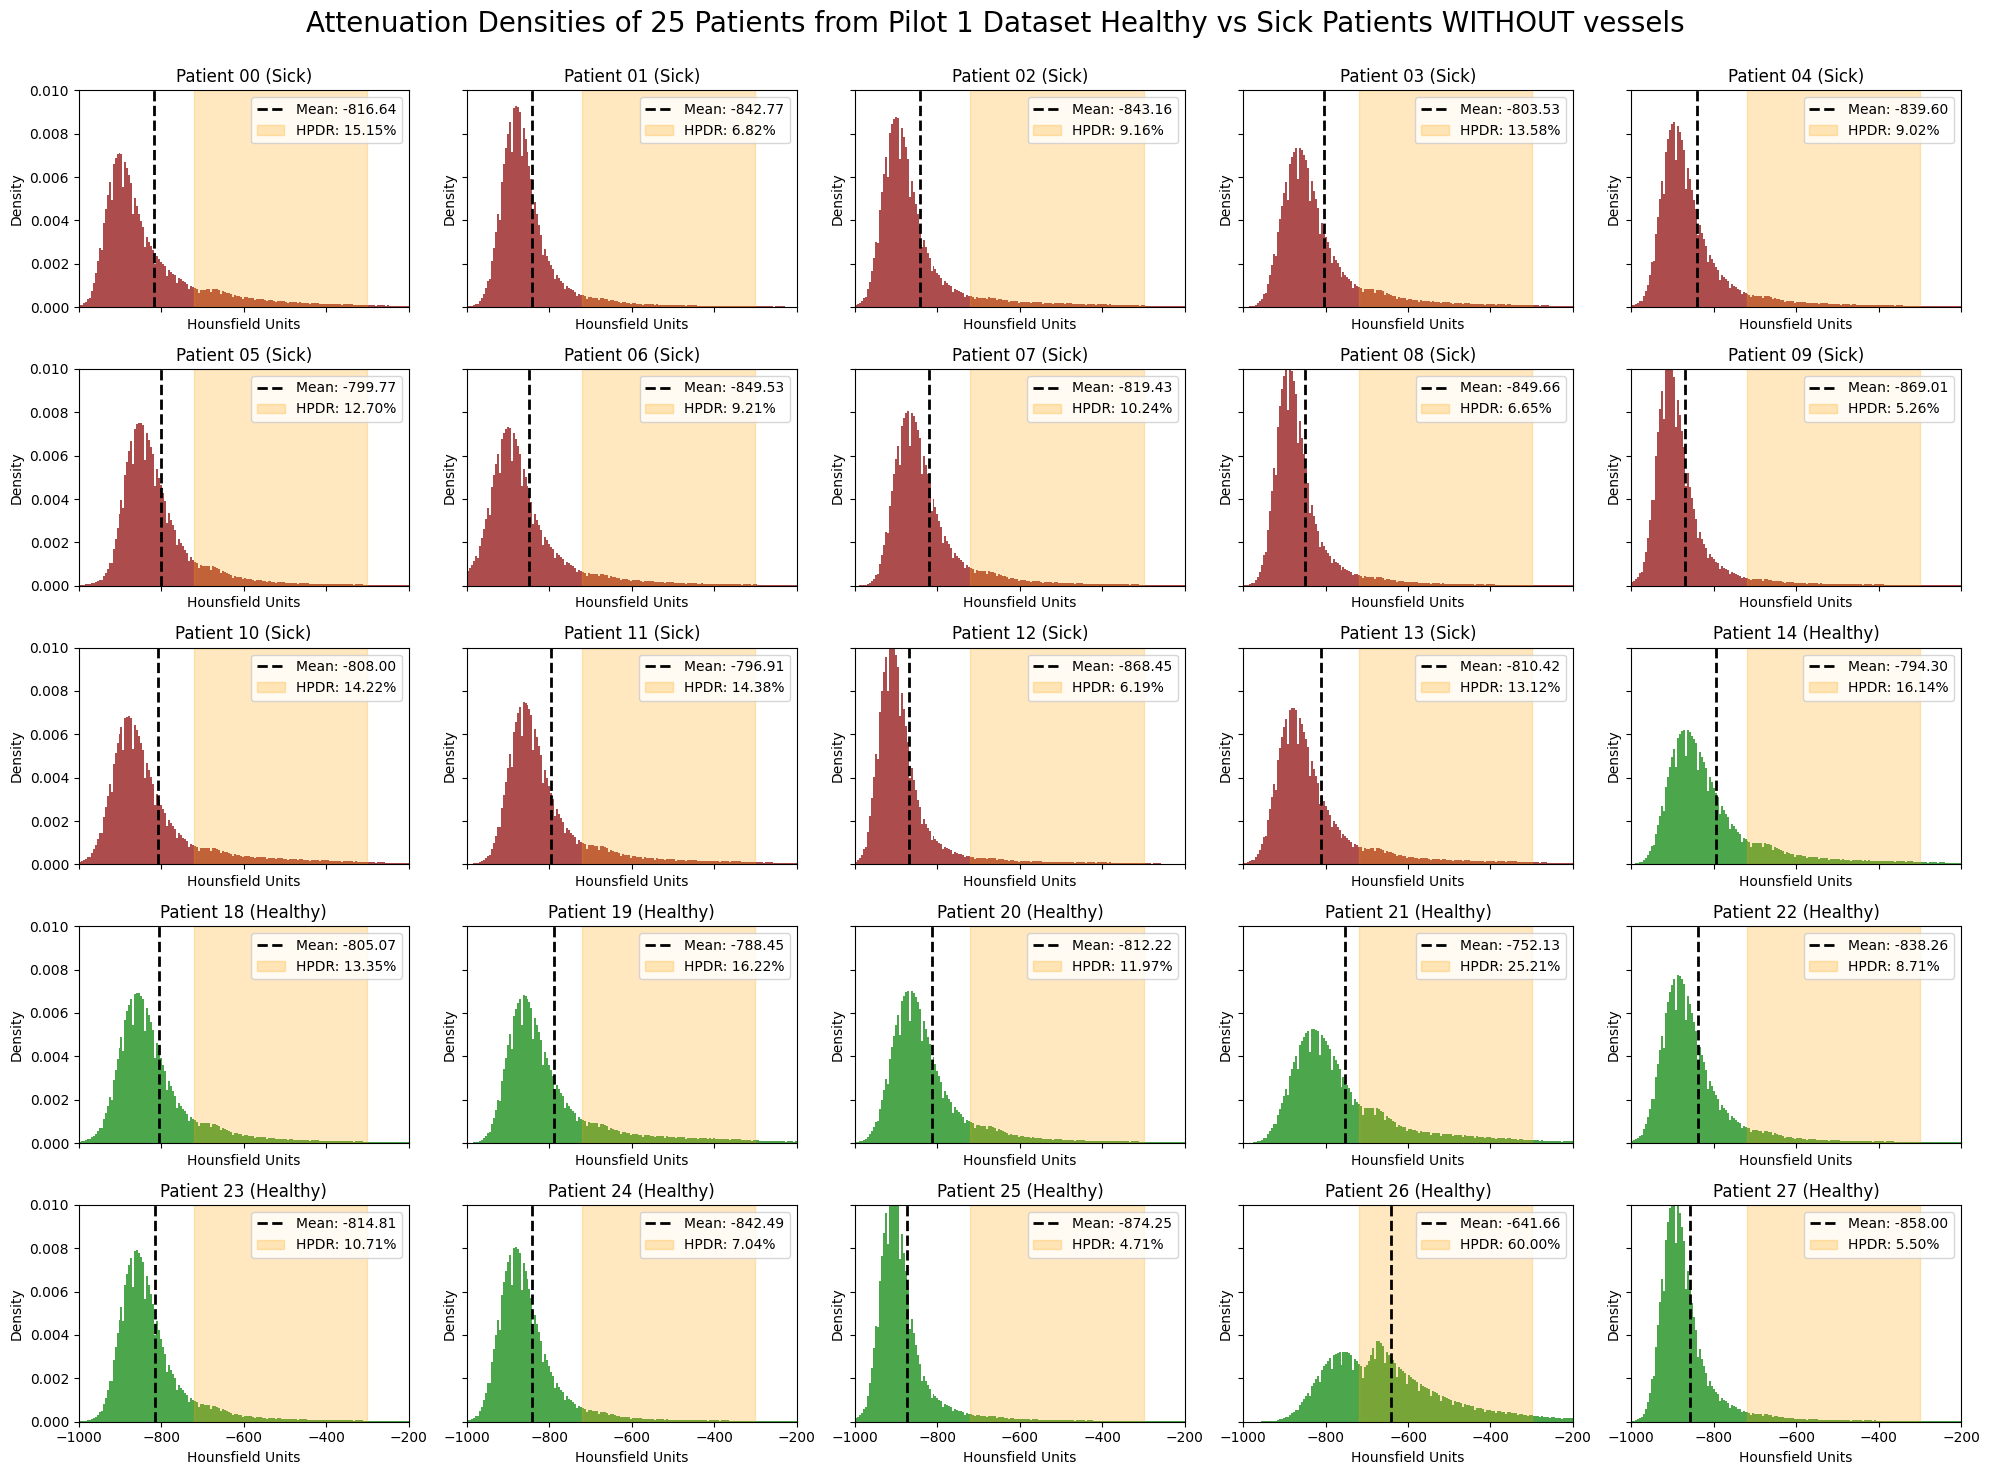

In [ ]:
# Calculate the number of plots required (5 columns per row)
total_patients = len(df_wo)
cols = 5
rows = (total_patients + cols - 1) // cols  # Round up to nearest whole row

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)

# Flatten axes to easily index into them
axes = axes.flatten()

# Define bins for all histograms
bins = np.linspace(-1000, 200, 250)

# Counter to track the subplot index
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df_wo.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'green' if label == 'healthy' else 'darkred'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HPDR=axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('attenuation Densities of 25 Patients from Pilot 1 Dataset Healthy vs Sick Patients WITHOUT vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

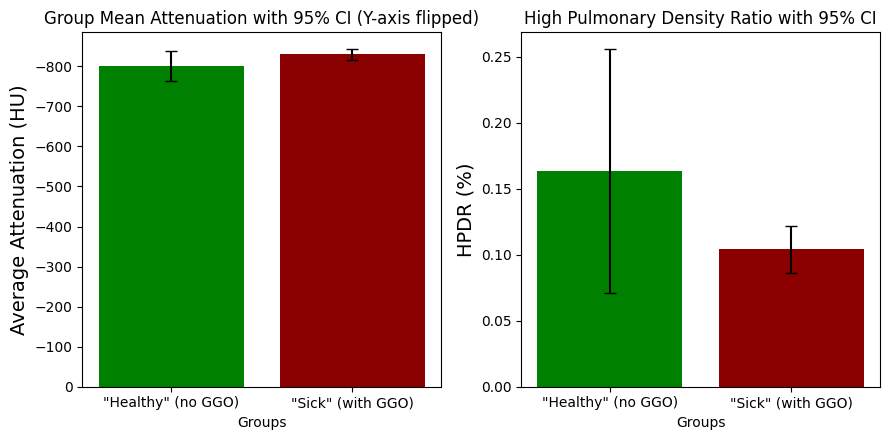

In [ ]:

# Calculate mean and standard error for attenuation
group_mean_attenuation_wo = df_wo.groupby('label')['average_attenuation'].mean()
group_sem_attenuation_wo = df_wo.groupby('label')['average_attenuation'].sem()

# Calculate 95% confidence interval range for attenuation
ci_attenuation_wo = 1.96 * group_sem_attenuation_wo

# Calculate mean and standard error for HPDR
group_mean_hpdr_wo = df_wo.groupby('label')['hpdr'].mean()
group_sem_hpdr_wo = df_wo.groupby('label')['hpdr'].sem()

# Calculate 95% confidence interval range for HPDR
ci_hpdr_wo = 1.96 * group_sem_hpdr_wo

# Define colors for each group (same for both plots)
colors = ['green' if label == 'healthy' else 'darkred' for label in group_mean_attenuation_wo.index]

# Define custom x-axis labels
custom_labels = ['"Healthy" (no GGO)', '"Sick" (with GGO)']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot 1: attenuation with flipped y-axis
ax1.bar(x=group_mean_attenuation_wo.index, height=group_mean_attenuation_wo, yerr=ci_attenuation_wo, capsize=4, color=colors)
ax1.set_xlabel('Groups')
ax1.set_ylabel('Average attenuation (HU)', fontsize=14)
ax1.set_title('Group Mean attenuation with 95% CI (Y-axis flipped)')
ax1.invert_yaxis()  # Flip the y-axis

# Set x-ticks and labels for the first plot
ax1.set_xticks(np.arange(len(group_mean_attenuation_wo)))  # Set the x-ticks based on the number of groups
ax1.set_xticklabels(custom_labels) 

# Plot 2: HPDR
ax2.bar(x=group_mean_hpdr_wo.index, height=group_mean_hpdr_wo, yerr=ci_hpdr_wo, capsize=4, color=colors)
ax2.set_xlabel('Groups')
ax2.set_ylabel('HPDR (%)', fontsize=14)
ax2.set_title('High Pulmonary Density Ratio with 95% CI')

# Set x-ticks and labels for the second plot
ax2.set_xticks(np.arange(len(group_mean_hpdr_wo)))  # Set the x-ticks based on the number of groups
ax2.set_xticklabels(custom_labels) 

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

# Comparison of subset of the attenuation of the lungs with and without vessels  

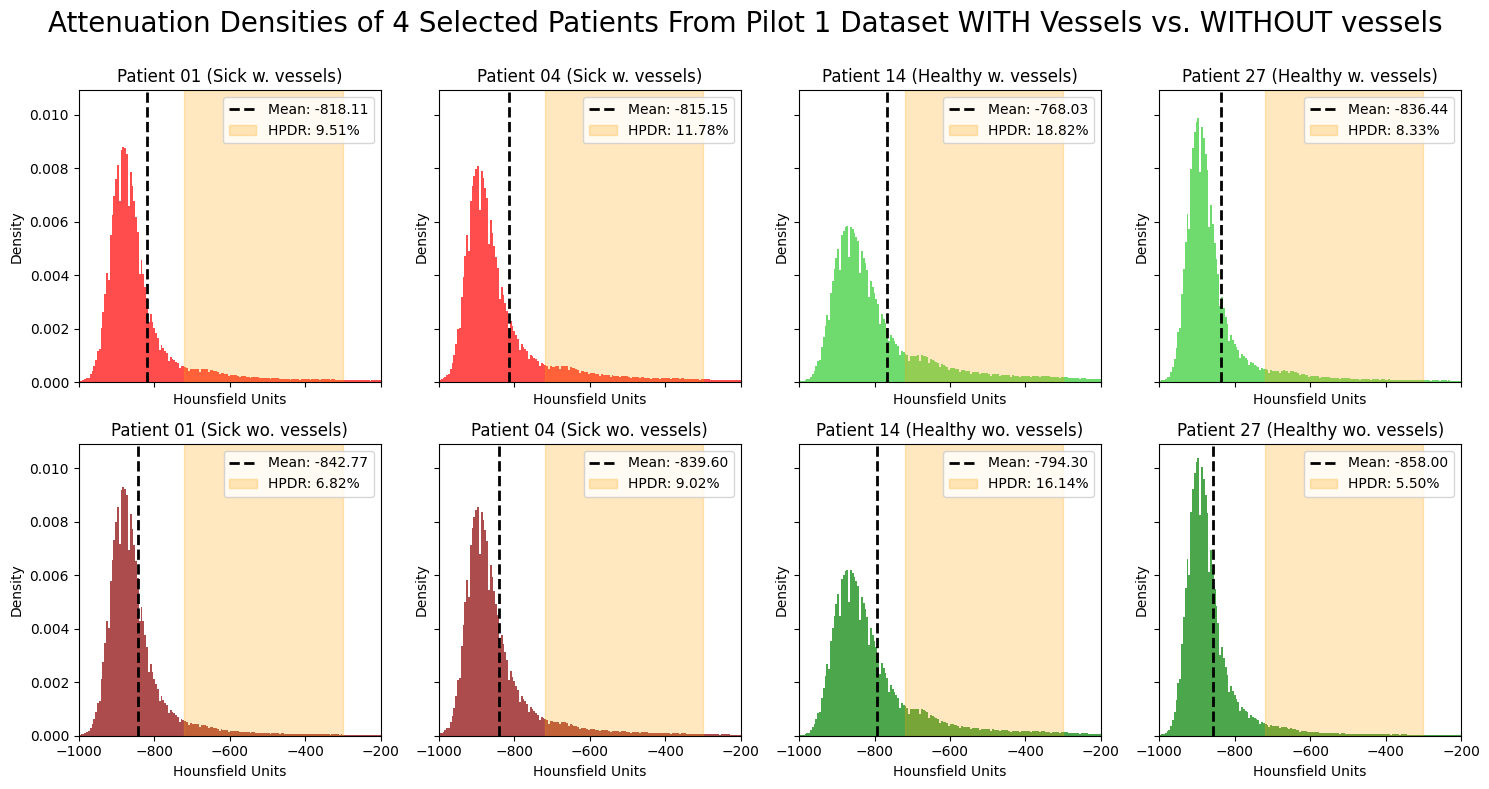

In [ ]:
#Selected patients for comparison
df_with_vessels_subset = df_with_vessels.loc[[1,4,14,24]] # Select 3 patients for comparison
df_wo_subset = df_wo.loc[[1,4,14,24]]  # Select 3 patients for comparison

# Create a grid of subplots (2 rows: 5 healthy on top, 5 sick on the bottom)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8), sharex=True, sharey=True)

# Flatten axes to easily index into them
axes = axes.flatten()

bins = np.linspace(-1000, 200, 250)

# Counter to track the subplot index
subplot_idx = 0


for _, row in df_with_vessels_subset.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'limegreen' if label == 'healthy' else 'red'
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()} w. vessels)")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    #make a horizontal line at y=100
    #axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HDPR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    subplot_idx += 1


for _, row in df_wo_subset.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'green' if label == 'healthy' else 'darkred'
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()} wo. vessels)")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    #axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HDPR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)

    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

plt.suptitle('attenuation Densities of 4 Selected Patients From Pilot 1 Dataset WITH Vessels vs. WITHOUT vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()

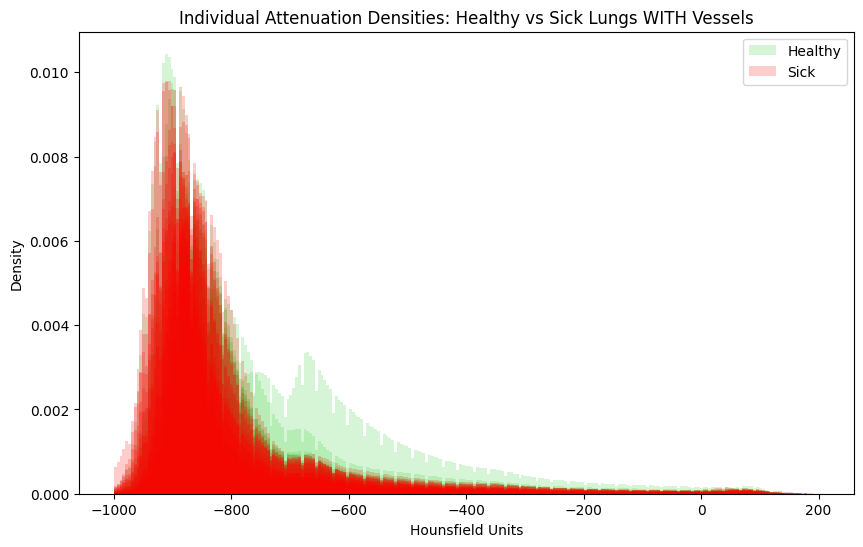

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define a consistent range for Hounsfield Units (-1000 to +1000)
bins = np.linspace(-1000, 200, 250)

# Plot individual histograms for each healthy sample
for attenuation_data in df_with_vessels[df_with_vessels['label'] == 'healthy']['attenuation']:
    plt.hist(attenuation_data, bins=bins, alpha=0.2, density=True, color='limegreen', label="Healthy" if 'Healthy' not in plt.gca().get_legend_handles_labels()[1] else "")
# Plot individual histograms for each sick sample
for attenuation_data in df_with_vessels[df_with_vessels['label'] == 'sick']['attenuation']:
    plt.hist(attenuation_data, bins=bins, alpha=0.2, density=True, color='red', label="Sick" if 'Sick' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add plot details
plt.title('Individual attenuation Densities: Healthy vs Sick Lungs WITH Vessels')
plt.xlabel('Hounsfield Units')
plt.ylabel('Density')
plt.legend()

# Display the plot
plt.show()

### This should probably not be used:

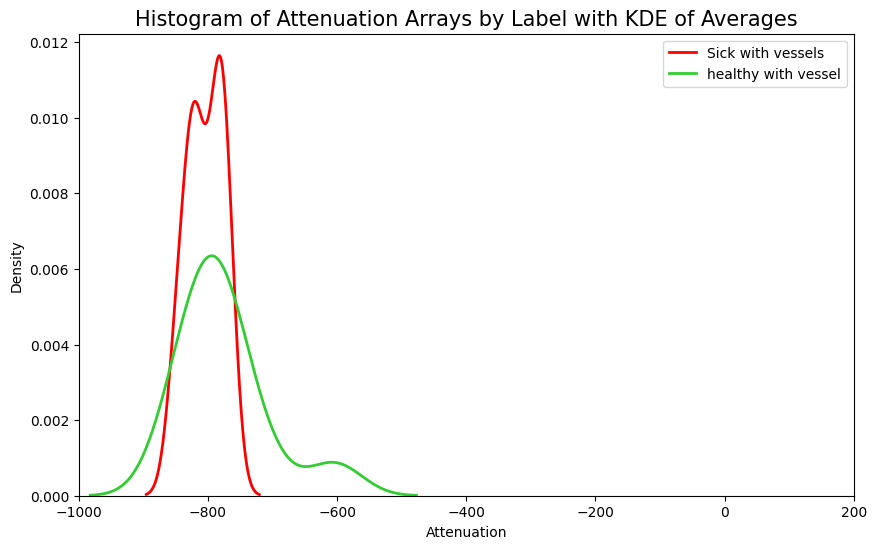

In [ ]:
plt.figure(figsize=(10, 6))
#sns.histplot(df_expanded, x='attenuation', hue='label', element='step', stat='density', common_norm=False, palette='coolwarm')

sns.kdeplot(df_with_vessels[df_with_vessels['label'] == 'sick']['average_attenuation'], color='red', label='Sick with vessels', lw=2)
sns.kdeplot(df_with_vessels[df_with_vessels['label'] == 'healthy']['average_attenuation'], color='limegreen', label='healthy with vessel', lw=2)

plt.title('Histogram of attenuation Arrays by Label with KDE of Averages', fontsize=15)
plt.xlim(-1000, 200)
plt.xlabel('attenuation')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()